In [2]:
import itertools
import random
import string
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random as rnd
import string
from pandas import DataFrame
from math import log2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import utils
from utils import normalizePixels, dataframe_to_array, row_to_img_grid, crop_pixel_row, apply_crop, do_nb, random_crop, \
    apply_random_image_crop


## Logisitc Regresssion


In [3]:
# reading in data

test_df = pd.read_csv('kaggleDataset/sign_mnist_test.csv')
train_df = pd.read_csv('kaggleDataset/sign_mnist_train.csv')

CLASS_COL = 'label'

print(f"Train data shape: {train_df.shape}, Test data shape: {test_df.shape}")


Train data shape: (27455, 785), Test data shape: (7172, 785)


In [4]:
# normalizing the pixel values since computation was taking a while

X_train, y_train = normalizePixels(train_df.iloc[:, 1:]), train_df.label
X_test, y_test = normalizePixels(test_df.iloc[:, 1:]), test_df.label

X_train, y_train = np.array(X_train), np.array(y_train)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, shuffle=True) # creating validation set

X_test, y_test = np.array(X_test), np.array(y_test)

# features, labels = dataframe_to_array(train_df)
# X_train, y_train = features,labels
# X_test, y_test = dataframe_to_array(test_df)

### Initial Results:

Simply training and evaluating LogisticRegression model on test data results in accuracy of :

In [8]:
# fitting a basic logReg model
MAX_ITER = 1200
clf = LogisticRegression(max_iter=MAX_ITER)
clf.fit(X_train, y_train)

score = round(clf.score(X_test, y_test), 4)
print(f"Initial Accuracy for logistic regression {score}")  # initial accuracy

Initial Accuracy for logistic regression 0.6887


In [5]:
# hyper parameter tuning using grid search

from sklearn.model_selection import PredefinedSplit, StratifiedKFold, StratifiedShuffleSplit

MAX_ITER = 1200

param_grid = {
    'C': [0.01, .1, 1, 100, 1000],
}

def k_folder(x_train, k):
    """ returns list of folds. each fold is a 2 length tuple of indices: (train_indices, test_indices) """
    n_folds = []
    for i in range(k):
        # splitting int o train and validation
        split_x = np.array([j for j in range(len(x_train)) if j % k != i])
        validation_split_x = np.array([j for j in range(len(x_train)) if j % k == i])

        np.random.shuffle(split_x)
        np.random.shuffle(validation_split_x)
        n_folds.append((split_x, validation_split_x))

    return n_folds


best_solver = 'newton-cg'   # fastest training time
model = LogisticRegression(max_iter=MAX_ITER)

cv = k_folder(X_train, 3)
# for train_idx, valid_idx in cv:
#     xtrain = X_train[train_idx]
#     ytrain = y_train[train_idx]
#     xTest = X_train[valid_idx]
#     yTest = y_train[valid_idx]

#     model.fit(xtrain, ytrain)
#     s = model.score(xTest, yTest)
#     print(s)

clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1)
clf.fit(X_train, y_train)


best_model = clf.best_estimator_

print("Best hyperparameters: ", clf.best_params_)


Best hyperparameters:  {'C': 1}


In [6]:
# running on test set with best hyper parameters

test_score = best_model.score(X_test, y_test)
print("Test accuracy for best model: ", test_score)

Test accuracy for best model:  0.692414947016174


In [7]:
display(clf.cv_results_)

{'mean_fit_time': array([58.23618007, 74.75943764, 90.44462029, 90.1399068 , 64.65269478]),
 'std_fit_time': array([0.32993757, 1.21375438, 4.97538202, 1.81199695, 3.71643249]),
 'mean_score_time': array([0.05882827, 0.05516148, 0.05307007, 0.03183087, 0.03250742]),
 'std_score_time': array([0.0063331 , 0.00798658, 0.01449688, 0.00077489, 0.00072424]),
 'param_C': masked_array(data=[0.01, 0.1, 1, 100, 1000],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 100}, {'C': 1000}],
 'split0_test_score': array([0.99814248, 0.99978147, 0.99989073, 0.99989073, 0.99989073]),
 'split1_test_score': array([0.99573864, 0.99978147, 1.        , 1.        , 1.        ]),
 'split2_test_score': array([0.99879795, 0.99989072, 1.        , 1.        , 1.        ]),
 'mean_test_score': array([0.99755969, 0.99981789, 0.99996358, 0.99996358, 0.99996358]),
 'std_test_score': array([1.31518824e-03, 5.1

### Data augmenting

We will data augment similar to naive bayes

We will attempt to crop the pixel vector uniformly. Meaning, reducing a layer of pixels around the image one by one and visualizing the resulting accuracies. We will crop the entire dataset in this manner and visualize the resulting accuracies without resizing, while implementing k fold cross validation to compare different magnitudes of size reductions. The intuition here is to eliminate background pixels that may affect probabilities.


In [19]:
# cross validation to determine best crop size

cropSizes = list(range(5))
scores = []
# filtered_x = apply_crop(X_train, crop_size=3)
# filtered_x_test = apply_crop(X_test, crop_size=3)

# clf = LogisticRegression(max_iter=MAX_ITER)
# clf.fit(filtered_x, y_train)

# score = round(clf.score(filtered_x_test, y_test), 4)
# print(f"Initial Accuracy for logistic regression {score}")  # initial accuracy

k = 5
for cropSize in cropSizes:
    filtered_x = apply_crop(X_train, crop_size=cropSize)  # cropping training data
    model = LogisticRegression(max_iter=MAX_ITER)

    # training data on model with cropped data using k fold cross validation
    k_scores = cross_val_score(model, filtered_x, y_train, cv=5)
    mean_score = k_scores.mean()
    score = round(mean_score, 4)
    scores.append(score)
    print(f"Score {score} for crop {cropSize}")

bestCropSize = cropSizes[np.argmax(scores)]


Score 1.0 for crop 0
Score 0.9999 for crop 1
Score 0.9998 for crop 2
Score 0.9998 for crop 3
Score 0.9992 for crop 4


Best crop size: 0, Best Validation accuracy 1.0


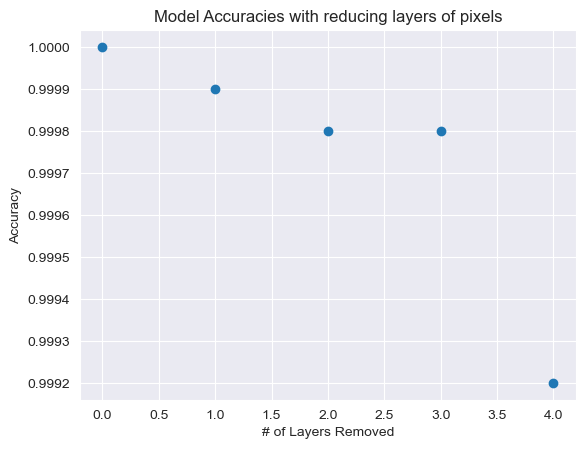

In [22]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Model Accuracies with reducing layers of pixels")
plt.xlabel('# of Layers Removed')
plt.ylabel("Accuracy")
plt.scatter(cropSizes, scores)

In [23]:
# applying best crop size to test set

# best cropsize is 0
filtered_x_train = apply_crop(X_train, crop_size=bestCropSize)
filtered_x_test = apply_crop(X_test, crop_size=bestCropSize)
clf = LogisticRegression(max_iter=MAX_ITER)
clf.fit(filtered_x_train, y_train)

best_test_accuracy = round(clf.score(filtered_x_test, y_test), 4)

print(f"Best test accuracy: {best_test_accuracy}")


Best test accuracy: 0.6924


### Random Crop Image Augmentation

We will attempt to randomly crop the images with a fixed crop size and then resize them back to original dimensions. Algorithm basically chooses a random point to begin crop from and generates a cropped image based on some crop_width and crop_height. This experiment will only do square crops. Will use k-fold cross validation to test different sizes. keep in mind original images are 28x28

In [10]:
cropSizes = list(range(18, 28, 2))
scores = []

for cropSize in cropSizes:
    filtered_x = apply_random_image_crop(X_train, cropSize, cropSize)

    # training data on model with cropped data using k fold cross validation
    clf = LogisticRegression(max_iter=MAX_ITER, solver=best_solver)
    k_scores = cross_val_score(clf, filtered_x, y_train, cv=cv,n_jobs=-1)
    mean_score = k_scores.mean()
    score = round(mean_score, 4)
    scores.append(score)

    print(f"score for crop size {cropSize}, {score}")

bestCropSize = cropSizes[np.argmax(scores)]


KeyboardInterrupt: 

In [ ]:
print(f"Best crop size: {bestCropSize}, Best Validation accuracy {round(max(scores), 3)}")
plt.title("Validation Accuracies with Random Crop Augmentation")
plt.xlabel('Crop Size')
plt.ylabel("Accuracy")
plt.scatter(cropSizes, scores)

In [ ]:
# random crop image for model

cropped_train = apply_random_image_crop(X_train, bestCropSize, bestCropSize)
best_random_crop_acc = do_nb(cropped_train, y_train, X_test, y_test)

print(f"Best random crop test accuracy : {round(best_random_crop_acc, 4)}")